In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys

import numpy as np
from tqdm import tqdm

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
# 21cmFAST
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c
from py21cmfast import plotting, cache_tools

print(f'Using 21cmFAST version {p21c.__version__}')

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230224


In [3]:
! lscpu | grep "CPU(s)"

CPU(s):                48
On-line CPU(s) list:   0-47
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47


In [4]:
p21c.UserParams(N_THREADS=32)

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


UserParams(BOX_LEN:300, DIM:600, FAST_FCOLL_TABLES:False, HII_DIM:200, HMF:1, MINIMIZE_MEMORY:False, NO_RNG:False, N_THREADS:32, PERTURB_ON_HIGH_RES:False, POWER_SPECTRUM:0, USE_2LPT:True, USE_FFTW_WISDOM:False, USE_INTERPOLATION_TABLES:True, USE_RELATIVE_VELOCITIES:False)

In [5]:
# darkhistory and dm21cm
import jax.numpy as jnp

if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    os.environ['DM21CM_DATA_DIR'] = '/data/submit/yitians/DM21cm'
    os.environ['DH_DIR'] = '/work/submit/yitians/darkhistory/DarkHistory'

sys.path.append('..')
sys.path.append(os.environ['DH_DIR'])
    
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools

import dm21cm.physics as phys
from dm21cm.common import abscs_nBs_test_2 as abscs
from dm21cm.interpolators import BatchInterpolator

## 1. Injection

### 1.1 Evoli Messinger Ferrara

In [6]:
def get_EMF_f_boxs(delta_B_box, x_e_box):
    
    return {
        'heat' : (1 + 2 * x_e_box) / 3,
        'ion'  : (1 - x_e_box) / 3,
        'exc'  : (1 - x_e_box) / 3,
    }

### 1.2 DarkHistory

In [7]:
dep_interp = BatchInterpolator(os.environ['DM21CM_DATA_DIR'] + '/transferfunctions/nBs_test_2/phot_dep_dlnz4.879E-2_renxo_ad.p')

In [8]:
def get_DH_f_boxs(delta_B_box, x_e_box, z=None, **process):
    
    # add check shape
    DIM = delta_B_box.shape[0]
    
    nBs_box = jnp.clip(jnp.array(1 + delta_B_box), 0, 15)
    nBs_in = nBs_box.flatten()
    x_box = jnp.array(x_e_box)
    x_in = x_box.flatten()
    
    spec = spectools.rebin_N_arr(np.array([1]), np.array([process['mDM']]), out_eng=abscs['photE'])
    spec_E = jnp.array(spec.N * spec.eng)
    spec_E /= jnp.sum(spec_E)
    f_boxs = dep_interp(1+z, spec.N, nBs_in, x_in, out_of_bounds_action='clip').reshape(DIM, DIM, DIM, 5) / spec.toteng()
    
    out_absc = np.array(dep_interp.abscs['out'])
    
    return {
        'heat' : f_boxs[:,:,:, np.where(out_absc=='heat')[0][0]  ],
        'ion'  : f_boxs[:,:,:, np.where(out_absc=='H ion')[0][0] ] + f_boxs[:,:,:, np.where(out_absc=='He ion')[0][0] ],
        'exc'  : f_boxs[:,:,:, np.where(out_absc=='exc')[0][0]   ],
    }

## 2. Run

In [9]:
def get_z_arr(z_start=p21c.global_params.Z_HEAT_MAX, z_end=20):
    
    z_arr = [z_end]
    while np.max(z_arr) < z_start:
        z_prev = (1 + np.max(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
        z_arr.append(z_prev)
    return np.array(z_arr[::-1][1:])

In [10]:
# cached runs
CACHE_DIR_BASE = '/scratch/submit/ctp/yitians/21cmFAST-cache'
os.listdir(CACHE_DIR_BASE)

['dh', 'baseline']

In [11]:
# config
RUN_NAME = 'dh'
run_mode = 'dh'

p21c.config['direc'] = f'/scratch/submit/ctp/yitians/21cmFAST-cache/{RUN_NAME}'
os.makedirs(p21c.config['direc'], exist_ok=True)

In [12]:
cache_tools.clear_cache()

2023-02-24 17:01:37,918 | INFO | Removing PerturbedField_e106c447f47e75899b437147919d952c_r54321.h5
INFO:21cmFAST:Removing PerturbedField_e106c447f47e75899b437147919d952c_r54321.h5
2023-02-24 17:01:37,931 | INFO | Removing IonizedBox_adb5c3d48f8109ed3b0e5672bfa99f39_r54321.h5
INFO:21cmFAST:Removing IonizedBox_adb5c3d48f8109ed3b0e5672bfa99f39_r54321.h5
2023-02-24 17:01:37,939 | INFO | Removing PerturbedField_38b26297c169f2a26284f18ad7cb84fb_r54321.h5
INFO:21cmFAST:Removing PerturbedField_38b26297c169f2a26284f18ad7cb84fb_r54321.h5
2023-02-24 17:01:37,946 | INFO | Removing PerturbedField_2dcc5127e17837a28a5440697fa9cde9_r54321.h5
INFO:21cmFAST:Removing PerturbedField_2dcc5127e17837a28a5440697fa9cde9_r54321.h5
2023-02-24 17:01:37,956 | INFO | Removing TsBox_7dd41ebce8bc50c0abfe1af65508900a_r54321.h5
INFO:21cmFAST:Removing TsBox_7dd41ebce8bc50c0abfe1af65508900a_r54321.h5
2023-02-24 17:01:37,966 | INFO | Removing TsBox_d54a033147b859a7962202168f492db2_r54321.h5
INFO:21cmFAST:Removing TsBox_d

In [13]:
# initialize
BOX_CF_LEN = 50 # [Mpc]
LOWRES_DIM = 50 # [1]
VOXEL_SIDE_CF_LENGTH = BOX_CF_LEN / LOWRES_DIM # [Mpc]

initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": LOWRES_DIM, "BOX_LEN": BOX_CF_LEN},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321, write=True
)

# redshift
# in DarkHistory: rs = 1 + z
p21c.global_params.ZPRIME_STEP_FACTOR = 1.05
z_arr = get_z_arr(z_end=5)
print('redshift')
print(z_arr)

# dark matter
swave_process = dict(
    mode = 'swave',
    mDM = 2e6, # [eV]
    sigmav = 1e-26, # [cm^-3 s^-1]
)
decay_process = dict(
    mode = 'decay',
    mDM = 1e6, # [eV]
    lifetime = 3e25, # [s]
)
process = swave_process

redshift
[33.75089682 32.09609221 30.52008781 29.01913125 27.58964881 26.22823696
 24.93165425 23.69681357 22.52077483 21.40073793 20.33403613 19.31812965
 18.35059966 17.42914254 16.55156432 15.71577554 14.91978623 14.16170117
 13.4397154  12.75210991 12.09724753 11.47356908 10.8795896  10.31389485
  9.77513796  9.26203615  8.77336776  8.3079693   7.86473266  7.44260254
  7.04057384  6.65768938  6.2930375   5.94575     5.615       5.3
  5.        ]


In [16]:
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

In [20]:
records = []
record = {}
i_slice = int(LOWRES_DIM/2)

# first step special case
i_z = 0
z = z_arr[i_z]

#print(f'i_z={i_z} 1+z={1+z:.3f}')

# perturbed_field to control redshift
perturbed_field = p21c.perturb_field(redshift=z, init_boxes=initial_conditions)
spin_temp = p21c.spin_temperature(
    perturbed_field=perturbed_field,
    previous_spin_temp=None,
    write=True
)
ionized_box = p21c.ionize_box(spin_temp=spin_temp)
brightness_temp = p21c.brightness_temperature(ionized_box=ionized_box,
                                              perturbed_field=perturbed_field,
                                              spin_temp=spin_temp)

# record['delta'] = perturbed_field.density[i_slice]
# record['T_s'] = spin_temp.Ts_box[i_slice]
# record['x_e'] = 1 - ionized_box.xH_box[i_slice]
# record['heat'] = np.zeros_like(record['delta'])
# record['ion'] = np.zeros_like(record['delta'])
# record['exc'] = np.zeros_like(record['delta'])
# record['heat_dT'] = np.zeros_like(record['delta'])
# record['T_b'] = brightness_temp.brightness_temp#[i_slice] # [K]
# records.append(record.copy())

pbar = tqdm(total = len(z_arr)-1)

for i_z, z in enumerate(z_arr[1:], start=1):

    #print(f'i_z={i_z} 1+z={1+z:.3f}', end=' ')

    # perturbed_field to control redshift
    perturbed_field = p21c.perturb_field(redshift=z, init_boxes=initial_conditions) # [1] | delta_DM

    # input boxes
    input_heating = p21c.input_heating(redshift=z, init_boxes=initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=z, init_boxes=initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=z, init_boxes=initial_conditions, write=False)

    if run_mode == '':
        if i_z == 1:
            print('Not injecting anything in this run!')

    elif run_mode == 'circle':
        input_heating.input_heating += get_circle_seq_at(50, 3, i_z)
        input_ionization.input_ionization += get_circle_seq_at(50, 5, 9-i_z) * 1e-3

    else:
        z_prev = z_arr[i_z-1]

        # 1. calculate total E_inj
        rho_DM_box = phys.rho_DM * (1+z)**3 * (1 + perturbed_field.density) # [eV cm^-3]
        n_B_box = phys.n_B * (1+z)**3 * (1 + perturbed_field.density) # [cm^-3] | assuming delta_B = delta_DM
        x_e_box = 1 - ionized_box.xH_box # [1]

        dE_inj_dVdt_box = phys.inj_rate_box(rho_DM_box, **process) # [eV cm^-3 s^-1]
        if process['mode'] == 'swave':
            struct_boost_factor = phys.struct_boost_func(model='erfc')(1+z)
            dE_inj_dVdt_box *= struct_boost_factor
            #print(f'1+B(z) = {struct_boost_factor}')

        dt = phys.dt_between_z(z_prev, z)
        dE_inj_per_B_box = dE_inj_dVdt_box * dt / n_B_box # [eV per B]

        # 2. get f
        if run_mode == 'dh':
            f_boxs = get_DH_f_boxs(perturbed_field.density, x_e_box, z=z, **process)
        elif run_mode == 'emf':
            f_boxs = get_EMF_f_boxs(perturbed_field.density, x_e_box, z=z, **process)
        else:
            raise NotImplementedError

        # 3. input
        input_heating.input_heating += np.array(2 / (3*phys.kB*(1+x_e_box)) * dE_inj_per_B_box * f_boxs['heat']) # [K]
        input_ionization.input_ionization += np.array(dE_inj_per_B_box * f_boxs['ion'] / phys.rydberg) # [1 per B]
        #input_jalpha.input_jalpha += dE_inj_per_B_box * f_boxs['exc'] / phys.lya_eng # [???]


    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=(None if i_z==0 else spin_temp),
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        write=True
    )

    ionized_box = p21c.ionize_box(spin_temp=spin_temp)

    brightness_temp = p21c.brightness_temperature(ionized_box=ionized_box,
                                                  perturbed_field=perturbed_field,
                                                  spin_temp=spin_temp)

    record['delta'] = perturbed_field.density[i_slice]
    record['T_s']   = spin_temp.Ts_box[i_slice]
    record['x_e']   = 1 - ionized_box.xH_box[i_slice]
    record['heat']  = ( dE_inj_per_B_box * f_boxs['heat'] / dt )[i_slice] # [eV s^-1 per B] | dE/dt per B
    record['ion']   = ( dE_inj_per_B_box * f_boxs['ion']  / dt )[i_slice] # [eV s^-1 per B] | dE/dt per B
    #record['exc']   = input_jalpha.input_jalpha[i_slice]
    record['heat_dT'] = input_heating.input_heating[i_slice] # [K]
    record['T_b'] = brightness_temp.brightness_temp[i_slice] # [K]
    records.append(record.copy())

    pbar.update()

100%|██████████| 36/36 [00:02<00:00, 11.91it/s]

## 3. View

In [ ]:
for i_z, z in enumerate(z_arr):
    x = records[i_z]['T_b']
    print(z, np.min(x), np.mean(x), np.max(x))

### 3.1 $\delta T_b$

In [21]:
plot_data = np.array([np.quantile(record['T_b'], [0.18, 0.5, 0.82]) for record in records])
np.save(f'../data/run_info/{RUN_NAME}_T_b.npy', plot_data)

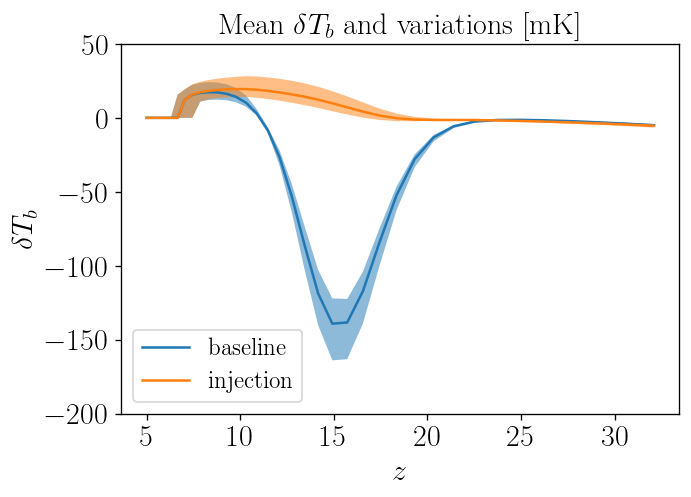

In [22]:
plot_data_base = np.load('../data/run_info/baseline_T_b.npy')
plot_data_inj  = np.load('../data/run_info/dh_T_b.npy')

fig, ax = plt.subplots()
ax.plot(z_arr[1:], plot_data_base[:,1], label='baseline')
ax.fill_between(z_arr[1:], plot_data_base[:,0], plot_data_base[:,2], alpha=0.5)
ax.plot(z_arr[1:], plot_data_inj[:,1], label='injection')
ax.fill_between(z_arr[1:], plot_data_inj[:,0], plot_data_inj[:,2], alpha=0.5)
ax.set(title=r'Mean $\delta T_b$ and variations [mK]', xlabel=r'$z$', ylabel=r'$\delta T_b$')
ax.set(ylim=(-200, 50));

ax.legend();

### 3.2 slices

In [ ]:
title={
    'delta' : r'$\delta_\mathrm{DM/B}$',
    'T_s'   : r'$T_\mathrm{spin}$ [K]',
    'x_e'   : r'$x_e$',
    'heat'  : r'$\epsilon_\mathrm{heat}$ [eV s$^{-1}$ per B]',
    'heat_dT' : r'heat $\Delta T$',
    'ion'   : r'$\epsilon_\mathrm{ion}$ [eV s$^{-1}$ per B]',
    'exc'   : r'$\epsilon_\mathrm{exc}$',
    'T_b'   : r'$T_b$',
}
vrange={
    'delta' : (-0.25, 0.75),
    'T_s'   : (60., 100.),
    'x_e'   : (0., 0.002),
    'heat'  : (0., 7e-18),
    'heat_dT' : (0, 40),
    'ion'   : (0., 7e-18),
    'exc'   : (0., 1.),
    'T_b'   : (-20., 0.)
}

for i_z, record in enumerate(tqdm(records)):

    fig, axs = plt.subplots(1, 6, figsize=(18, 4))
    for i, (k, x) in enumerate(record.items()):
        if k == 'T_b':
            continue
        im = axs[i].imshow(x, vmin=vrange[k][0], vmax=vrange[k][1])
        axs[i].set(title=title[k], xticks=[], yticks=[])
        axs[i].text(28, 47, f'z={z_arr[i_z]:.3f}', color='w')
        fig.colorbar(im, ax=axs[i], orientation='horizontal', shrink=0.9)
    fig.savefig(f'plots/tmp/{i_z}.png')
    #plt.close()

In [26]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "plots/tmp/*.png"
fp_out = "plots/dh_dT.gif"

# use exit stack to automatically close opened images
flist = glob.glob(fp_in)
with contextlib.ExitStack() as stack:
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(flist, key=lambda x: int(os.path.basename(x).split('.')[0])))
    # extract  first image from iterator
    durations = np.full(len(flist), 500)
    durations[-1] = 1500
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=list(durations), loop=0)

### 3.3 lightcone

In [ ]:
p21c.run_lightcone(redshift=5)

# Archive

## A. Some uniform calculation for scale

In [25]:
swave_process = dict(
    mode = 'swave',
    mDM = 2e6, # [eV]
    sigmav = 1e-26, # [cm^3 s^-1]
)
decay_process = dict(
    mode = 'decay',
    mDM = 4e6, # [eV]
    lifetime = 3e25, # [s]
)
process = swave_process

$$\mathcal{E}^{inj}=\frac{1}{n_B}\frac{dE}{dtdV}=(1+z)^3\frac{\Omega_{DM}^2}{\Omega_B}\rho_c(1+B(z))m_pc^2\frac{\langle\sigma v\rangle}{m_{DM}}$$

In [26]:
E_inj = phys.omega_DM**2 / phys.omega_baryon * phys.rho_crit * phys.m_p * process['sigmav'] / process['mDM']
print(f"E_inj = (1+z)^3 (1+B) * {E_inj:.4e} eV / s")

E_inj = (1+z)^3 (1+B) * 3.1821e-20 eV / s


$$\epsilon^{DM}_{heat}=f_{heat}\mathcal{E}^{inj}$$

In [27]:
z_high, z_low = 34.91712652, 33.20678716
delta_B = jnp.array([0.])
x_e = jnp.array([0.1])
f_boxs = get_DH_f_boxs(delta_B, x_e, z=z_high, **process)

eDMheat = (1+z_high)**3 * f_boxs['heat'].flatten()[0] * E_inj
print(f"e_DM_heat = (1+B) * {eDMheat:.4e} eV / s")

e_DM_heat = (1+B) * 1.1110e-19 eV / s


$$\Delta T=\frac{2}{3k_B(1+x_e)}\,\Delta t\,\epsilon^{DM}_{heat}$$

In [28]:
dT =  2 / (3*phys.kB) * phys.dt_between_z(z_high, z_low) * eDMheat / (1+x_e[0])
print(f"dT = (1+B) * {1000*dT:.4f} mK")

dT = (1+B) * 149.2254 mK


## B. Plotting

[Text(0.5, 1.0, 'input ionization'), [], []]

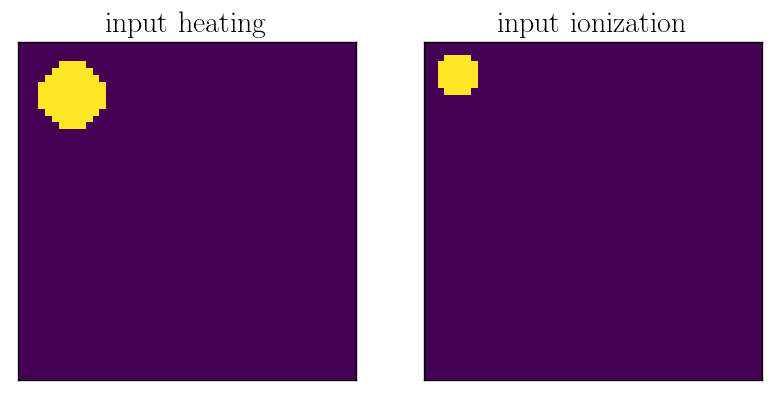

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title=r'input heating', xticks=[], yticks=[])
axs[1].set(title=r'input ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

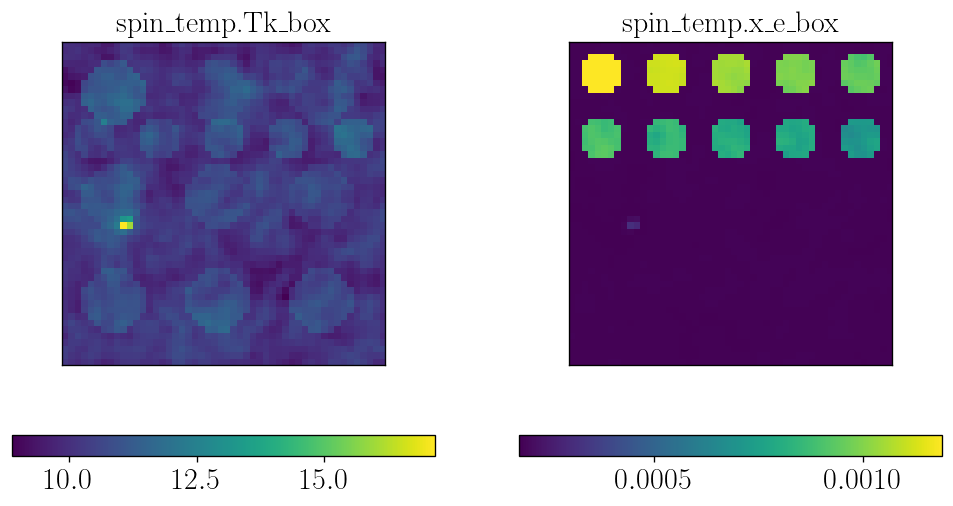

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')